### Initial exploration of data features
In this notebook we will analyse some of the initial data, by finding out what features are available, what granularity the data comes in, as well as seeing if there is any obvious noise we need to take into account.

In [1]:
experiment = "data/experiments/experiment_2/"

In [2]:
## Loading in the data from data/experiments/experiment_1, which contains button_presses.csv for the labels, and other csv files for the features. In experiments_1/meta we have the system time and the device info
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_data(path, within_range=True, temp_features=True):
    # Load the starting time
    time_df = pd.read_csv(path + 'meta/time.csv')
    start_time = time_df.loc[time_df['event'] == 'START', 'system time'].iloc[0]

    data_frames = []
    for filename in os.listdir(path):
        if filename.endswith(".csv"):
            df = pd.read_csv(path + filename)
            # Check if 'Time (s)' column exists
            if 'Time (s)' in df.columns:
                # Convert 'Time (s)' column to datetime index for each dataframe
                df.index = pd.to_datetime(df['Time (s)'], unit='s', origin=pd.Timestamp(start_time, unit='s'))
                data_frames.append(df)
            else:
                print(f"'Time (s)' column not found in file: {filename}")
                print(f"Columns found: {df.columns}")
    
    # Concatenate dataframes
    data = pd.concat(data_frames)
    
    # resample to 10 Hz
    data_resampled = data.resample('100ms').mean()
    
    # Load label dataset
    labels = pd.read_csv(path+'button_presses.csv', names=['Timestamp', 'Label'])
    labels['Timestamp'] = pd.to_datetime(labels['Timestamp'], unit='s')
    
    # Filter timestamps within label range
    first_label_timestamp = labels['Timestamp'].iloc[0]
    last_label_timestamp = labels['Timestamp'].iloc[-1]
    data_resampled = data_resampled[(data_resampled.index >= first_label_timestamp) & (data_resampled.index <= last_label_timestamp)]
    
    if len(data_resampled):
        # Add labels
        def get_recent_label(row):
            return labels[labels['Timestamp'] <= row.name]['Label'].iloc[-1]

        data_resampled['Label'] = data_resampled.apply(get_recent_label, axis=1)

        # Add temporal label features
        def get_time_until_next(row):
            next_label = labels[labels['Timestamp'] > row.name]['Timestamp'].min()
            if pd.isnull(next_label):
                return pd.NaT
            else:
                return (next_label - row.name).total_seconds()

        def get_time_since_previous(row):
            previous_label = labels[labels['Timestamp'] < row.name]['Timestamp'].max()
            if pd.isnull(previous_label):
                return pd.NaT
            else:
                return (row.name - previous_label).total_seconds()

        data_resampled['Time_Until_Next_Label'] = data_resampled.apply(get_time_until_next, axis=1)
        data_resampled['Time_Since_Previous_Label'] = data_resampled.apply(get_time_since_previous, axis=1)
        data_resampled['Time_Until_Next_Label'] = data_resampled['Time_Until_Next_Label'].fillna(0.0)
        data_resampled['Time_Since_Previous_Label'] = data_resampled['Time_Since_Previous_Label'].fillna(0.0)
    return data_resampled

data = load_data(experiment)
# display(data)

'Time (s)' column not found in file: button_presses.csv
Columns found: Index(['1686727387', 'break-btn'], dtype='object')


In [3]:
import xml.etree.ElementTree as ET
from datetime import datetime

# Define a conversion function
def convert_timestamp(timestamp):
    datetime_obj = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.%fZ')
    return datetime_obj

# Load the xml file into a dataframe
def load_xml(path, convert_time=True):
    # Parse the XML file
    tree = ET.parse(path + 'activity_11340269258.tcx')
    root = tree.getroot()

    # Define the namespaces
    namespaces = {
        'tc': 'http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2',
        'activity': 'http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2',
        'ns3': 'http://www.garmin.com/xmlschemas/ActivityExtension/v2',
        'ns5': 'http://www.garmin.com/xmlschemas/ActivityGoals/v1',
        'ns2': 'http://www.garmin.com/xmlschemas/UserProfile/v2',
        'xsi': 'http://www.w3.org/2001/XMLSchema-instance',
        'ns4': 'http://www.garmin.com/xmlschemas/ProfileExtension/v1'
    }

    # Extract data from XML and create a dictionary
    xml_data = {'Time': [], 'AltitudeMeters': [], 'HeartRate': []}

    for trackpoint in root.findall('.//tc:Trackpoint', namespaces):
        time = trackpoint.find('tc:Time', namespaces).text
        altitude = trackpoint.find('tc:AltitudeMeters', namespaces).text
        heart_rate = trackpoint.find('tc:HeartRateBpm/tc:Value', namespaces).text

        xml_data['Time'].append(time)
        xml_data['AltitudeMeters'].append(altitude)
        xml_data['HeartRate'].append(heart_rate)

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(xml_data)
    
    df['AltitudeMeters'] = df['AltitudeMeters'].astype(float)
    df['HeartRate'] = df['HeartRate'].astype(float)
    
    # Apply the conversion function to the 'Time' column
    if convert_time:
        df['Time'] = df['Time'].apply(convert_timestamp)
    
    df = df.set_index('Time')
    
    return df

xml_data = load_xml(experiment)

In [4]:
# Merges the csv and xml data
def merge(data, xml_data):
    first_timestamp = data.index[0]
    last_timestamp = data.index[-1]
    df_filtered = xml_data[(xml_data.index >= first_timestamp) & (xml_data.index <= last_timestamp)]
    merged_df = pd.merge(data, df_filtered, left_index=True, right_index=True, how='left')
    
    return merged_df
df = merge(data, xml_data)
# df

## Interpolation

In [5]:
from ImputationMissingValues import ImputationMissingValues

# Interpolates specified columns of the dataframe (all columns with NaNs as default)
def interpolate(df, columns=None):
    if columns is None:
        columns = df.columns[df.isna().any()].tolist()
    
    imputer = ImputationMissingValues()
    for column in columns:
        df = imputer.impute_interpolate(df, column)
    
    return df

interpolated_df = interpolate(df)
# interpolated_df

## Principal Component Analysis

In [6]:
from DataTransformation import PrincipalComponentAnalysis

# PCA function where number of PC's and columns used can be specified (all columns but the label as default).
# Adds new PCA columns to the dataframe
def pca(df, num_comp, columns=None):
    if columns is None:
        columns = df.drop('Label', axis=1).columns
    PCA = PrincipalComponentAnalysis()
    pca_df = PCA.apply_pca(df, columns, num_comp)
    
    return pca_df

pca_df = pca(interpolated_df, 3)
pca_df

,Time (s),Distance (cm),X (hPa),X (m/s^2),Y (m/s^2),Z (m/s^2),Latitude (°),Longitude (°),Height (m),Velocity (m/s),...,Y (rad/s),Z (rad/s),Label,Time_Until_Next_Label,Time_Since_Previous_Label,AltitudeMeters,HeartRate,pca_1,pca_2,pca_3
Time (s),,,,,,,,,,,,,,,,,,,,,
2023-06-14 07:23:07.000,4.049522,0.0,1015.845718,4.139773,0.052481,2.511321,52.355727,4.956966,-2.204683,-1.0,...,0.237603,-0.012066,break-btn,185.0,0.0,-33.599998,81.0,0.269019,0.347258,-0.089637
2023-06-14 07:23:07.100,4.149481,0.0,1015.845718,6.540396,1.121592,1.132984,52.355727,4.956966,-2.204683,-1.0,...,0.161938,0.032972,break-btn,184.9,0.1,-33.599998,81.1,0.269884,0.346129,-0.089488
2023-06-14 07:23:07.200,4.249441,0.0,1015.845718,5.623285,1.644055,-0.409022,52.355727,4.956966,-2.204683,-1.0,...,0.298730,-0.215380,break-btn,184.8,0.2,-33.599998,81.2,0.270253,0.345332,-0.089907
2023-06-14 07:23:07.300,4.349400,0.0,1015.845718,4.923836,2.154488,-1.257709,52.355727,4.956966,-2.204683,-1.0,...,1.104726,-0.138122,break-btn,184.7,0.3,-33.599998,81.3,0.267610,0.345051,-0.092110
2023-06-14 07:23:07.400,4.449360,0.0,1015.845718,2.254366,-0.239731,0.150786,52.355727,4.956966,-2.204683,-1.0,...,1.348128,-0.108369,break-btn,184.6,0.4,-33.599998,81.4,0.260943,0.346117,-0.100008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-14 08:43:49.600,4846.651563,0.0,1016.020279,4.339242,-1.138275,1.936308,52.355825,4.956949,3.069094,-1.0,...,0.188239,-0.440058,lowering-btn,0.4,11.6,-35.680000,138.4,0.163757,-0.084090,-0.318390
2023-06-14 08:43:49.700,4846.751516,0.0,1016.020279,3.911377,-1.391997,2.150035,52.355825,4.956949,3.069094,-1.0,...,0.202553,-0.382123,lowering-btn,0.3,11.7,-35.760000,138.3,0.158951,-0.082730,-0.317795
2023-06-14 08:43:49.800,4846.851468,0.0,1016.020279,3.825893,-0.686426,2.122043,52.355825,4.956949,3.069094,-1.0,...,-0.162471,-0.350939,lowering-btn,0.2,11.8,-35.840000,138.2,0.155100,-0.081891,-0.316779


## Plotting

FileNotFoundError: [Errno 2] No such file or directory: 'data/experiments/experiment_2/figures/line_plot.pdf'

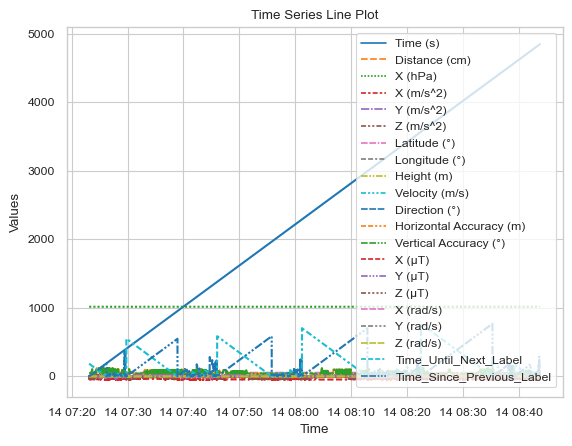

In [7]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_data(data, output_path):
    # Set Seaborn style and context
    sns.set_style("whitegrid")
    sns.set_context("paper")

    # Line plot
    fig, ax = plt.subplots()
    sns.lineplot(data=data, palette="tab10", linewidth=1.5, ax=ax)
    ax.set_title('Time Series Line Plot')
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    fig.savefig(output_path + 'line_plot.pdf')

    # Distribution of the data
    fig, ax = plt.subplots()
    sns.kdeplot(data=data, ax=ax, fill=True)
    ax.set_title('Data Distribution Plot')
    ax.set_xlabel('Values')
    fig.savefig(output_path + 'distribution_plot.pdf')

    # Boxplots of the data
    fig, ax = plt.subplots()
    sns.boxplot(data=data, palette="tab10", ax=ax)
    ax.set_title('Data Boxplot')
    fig.savefig(output_path + 'boxplot.pdf')

    # Correlation matrix of the data
    fig, ax = plt.subplots()
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', ax=ax)
    ax.set_title('Data Correlation Matrix')
    fig.savefig(output_path + 'correlation_matrix.pdf')

    # Pairwise relationships
    fig, ax = plt.subplots()
    sns.pairplot(data)
    ax.set_title('Pairwise Relationships')
    fig.savefig(output_path + 'pairwise_relationships.pdf')

    # Histogram
    fig, ax = plt.subplots()
    data.hist(bins=30, ax=ax)
    ax.set_title('Data Histogram')
    fig.savefig(output_path + 'histogram.pdf')

    # Time series decomposition
    for col in data.columns:
        try:
            result = seasonal_decompose(data[col], model='additive', period=1)
            fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,8))
            result.observed.plot(ax=ax1)
            ax1.set_ylabel('Observed')
            result.trend.plot(ax=ax2)
            ax2.set_ylabel('Trend')
            result.seasonal.plot(ax=ax3)
            ax3.set_ylabel('Seasonal')
            result.resid.plot(ax=ax4)
            ax4.set_ylabel('Residual')
            fig.savefig(output_path + f'{col}_decomposition.pdf')
        except:
            print(f"Cannot decompose {col}")

output_path = experiment + "figures/"
plot_data(data, output_path)